In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'state-farm-distracted-driver-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5048%2F868335%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T111723Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f6762fbf82ba62a5f2d0aa26c04d191fa1a26c7d9a7ba425ca3d5aeb8219f706ed2043dddde790f16aa629c1fb9b6a54b2e2cc2da338e99b9d3c14a021ab91c948cb51a7e96c5d8115adca84f3d69fc2f5c5b39a1b7da51c878e27339bc7583f437400474a2dbeca472ebb5ef69dc8e7d5c557e9011b10f8dfeff054bee12f437344b26cdc14e2247da0e2d0850e8d1bbaff0d90e489dc89bdc95dbe3e771f91eeefd2085a02e77507ba275c7608c890d7b8f7c33e424697eb0b4a650a8a68bfb6c81fd6a400b74e355aa92c991bbc0bc5876e9cf3735ef86fe7fa9c9fab48d062d7f067cb6a046e74ca26c32c0bbe731d4cdcc08978783b644db27ad2a5215,ensembling-model:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4533052%2F7752806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T111724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40892360f3d8336ccc64e5d0984f47be6e91c9645811c6f6f48572373df2c5d593bfb9a8d437e1a7cae6971b8c51589d0fb5113bb29157453514bdd047afebf732a133cf9f9bf677737373cd75920b3b3695519a767d1e325fb16c21646b7c41aab00b7bf2ed3bfbacbd665a83d2a2a25b5fd5c4fd4c5eb758bc8c20f889476a0fe17bfa63970dd7ed60c6fcf7736ee22068730a800b42714bddacb884abeba97971f0093c75bdcf3ccbc6b29af1b0941739ac7082296867f60b61ccae9aeb11e7f56df0a49201f23ae4e1d2fbbd6cd32b9ded6e4d6bb6a99638cbca5c43b3bb3f934c00655b873315e40451a7df77103323313f406a754fd737482c264cb19f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import BatchNormalization
from keras import optimizers


2024-03-04 04:26:35.111586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 04:26:35.111686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 04:26:35.271244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
driver_details = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [ ]:
## Getting all the images

val_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        if driver in driv_selected:
            val_image.append([img,label,driver])
            image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
## Randomly shuffling the images

import random
random.shuffle(val_image)

In [ ]:
## Splitting the train and test

X_test = []
y_test = []
D_test = []
true_test = []

for features,labels,drivers in val_image:
    X_test.append(features)
    y_test.append(labels)
    D_test.append(drivers)
    true_test.append(labels)


print (len(X_test),len(y_test))

3692 3692


In [ ]:
## Converting images to nparray. Encoding the Y

X_test = np.array(X_test).reshape(-1,224,224,3)
y_test = to_categorical(y_test)


print (X_test.shape)

(3692, 224, 224, 3)


### Exception Model


In [ ]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')



from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception




model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers

x=GlobalAveragePooling2D()(output_xception_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(inputs=xception_input, outputs=x)
xception_pretrained.load_weights('/kaggle/input/ensembling-model/xception_weights_aug_alltrained_setval_sgd3 (1).hdf5')



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# labels is the image array

from sklearn.metrics import accuracy_score, confusion_matrix

model1_prediction = []
model1_pred_class = []

model1_prediction = xception_pretrained.predict(X_test)
print('Images Predicted until now:',len(model1_prediction))


for i in range(len(model1_prediction)):
    model1_pred_class.append(np.where(model1_prediction[i] == np.amax(model1_prediction[i]))[0][0])


print('The accuracy of this model over validation set is:',accuracy_score(true_test,model1_pred_class))
confusion_matrix(true_test,model1_pred_class)


  4/116 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step 

I0000 00:00:1709526893.197734     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/116 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step
Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8041711809317443


array([[254,   1,   5,   2,   5,  55,   0,   0,   3,  87],
       [  0, 327,   0,   3,   0,   0,   0,   3,   3,   3],
       [  0,   0, 343,   0,   0,   0,   0,   0,   5,   0],
       [  4,   0,   0, 391,   0,   0,   0,   0,   4,   0],
       [ 14,   0,   0,   0, 317,   0,   0,   1,  61,   3],
       [  2,   0,   1,   2,   6, 362,   0,   0,   1,  29],
       [  0,   0,   4,   0,   1,   0, 308,   8,  70,   1],
       [  0,   0,   1,   0,   1,   0,   0, 330,   0,   2],
       [  1,   3,  27,   0,   4,   0,  42,  98, 141,  16],
       [ 63,   0,   2,   1,  14,  52,   1,   5,   3, 196]])

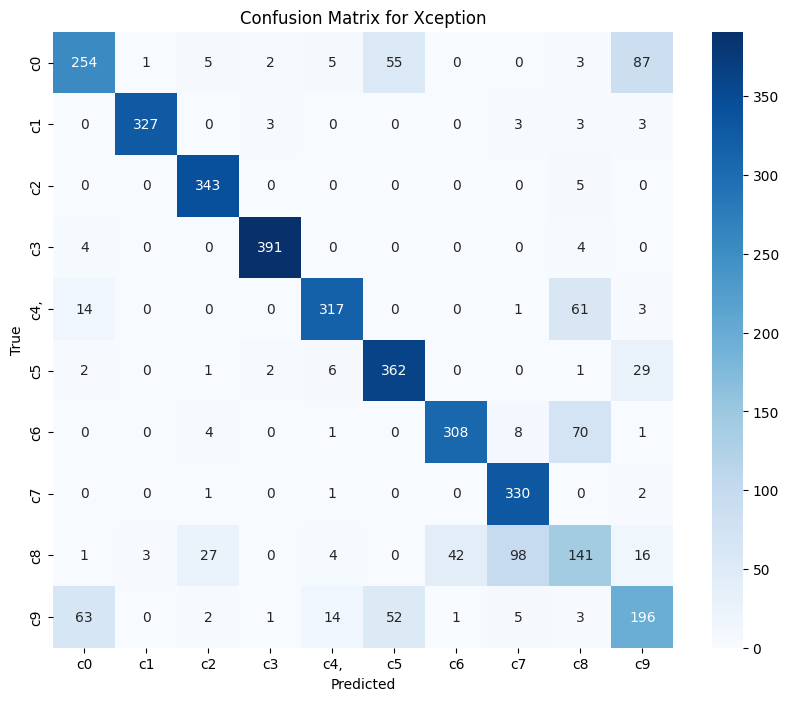

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_test, model1_pred_class)
labels = ['c0','c1','c2','c3','c4,','c5','c6','c7','c8','c9']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Xception')
plt.show()

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model1_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.56


### RESNET 50 Model


In [ ]:
## Defining the input
from keras.layers import Input
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

output_resnet50_conv = model_resnet50_conv(resnet50_input)

x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)
resnet50_pretrained = Model(inputs = resnet50_input, outputs = x)

resnet50_pretrained.load_weights('/kaggle/input/ensembling-model/resnet_weights_aug_alltrained_sgd2_setval.hdf5')

print('Model is Loaded')



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model is Loaded


In [ ]:
# labels is the image array


model3_prediction = []
model3_pred_class = []

model3_prediction = resnet50_pretrained.predict(X_test)
print('Images Predicted until now:',len(model3_prediction))


for i in range(len(model3_prediction)):
    model3_pred_class.append(np.where(model3_prediction[i] == np.amax(model3_prediction[i]))[0][0])


print('The accuracy of this model over validation set is:',accuracy_score(true_test,model3_pred_class))
confusion_matrix(true_test,model3_pred_class)


116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8515709642470206


array([[364,   1,   1,   0,   5,   8,   0,   0,  15,  18],
       [  1, 308,   0,   0,   1,   1,   2,   0,  25,   1],
       [  0,   0, 273,   0,   0,   0,   0,   0,  75,   0],
       [  2,   1,   0, 386,   6,   4,   0,   0,   0,   0],
       [  1,   0,   0,   0, 346,  20,   0,   1,  24,   4],
       [  3,   0,   0,   0,   1, 398,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 339,   0,  53,   0],
       [  1,   0,   0,   0,   4,   1,   0, 311,   1,  16],
       [ 12,   0,  18,   0,   5,   0,  22,  60, 210,   5],
       [ 60,   1,   0,   0,   9,  52,   1,   0,   5, 209]])

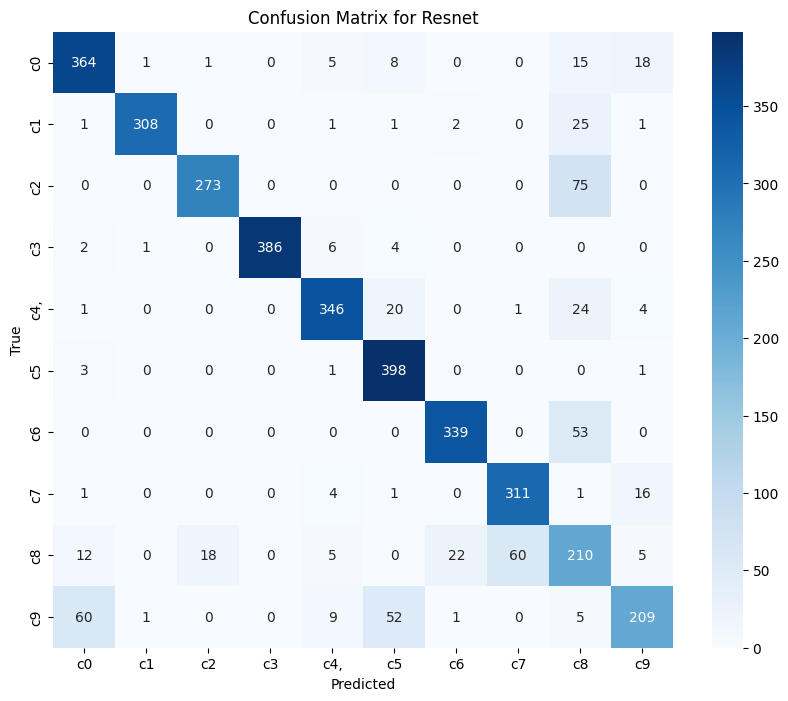

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_test, model3_pred_class)
labels = ['c0','c1','c2','c3','c4,','c5','c6','c7','c8','c9']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Resnet')
plt.show()

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model3_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

### Mobilenet Model


In [ ]:
## Defining the input

from keras.layers import Input
from keras.models import Model


mbnet_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input


model_mbnet_conv = MobileNet(weights='imagenet',include_top=False)


x=model_mbnet_conv.output
x=GlobalAveragePooling2D()(x)
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

mbnet_model = Model(inputs=model_mbnet_conv.input, outputs=preds)

mbnet_model.load_weights('/kaggle/input/ensembling-model/mobilenet_sgd_nolayers.hdf5')

print('The Model is loaded')

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
The Model is loaded


In [ ]:
# labels is the image array


model8_prediction = []
model8_pred_class = []

model8_prediction = mbnet_model.predict(X_test)
print('Images Predicted until now:',len(model8_prediction))


for i in range(len(model8_prediction)):
    model8_pred_class.append(np.where(model8_prediction[i] == np.amax(model8_prediction[i]))[0][0])


print('The accuracy of this model over validation set is:',accuracy_score(true_test,model8_pred_class))
confusion_matrix(true_test,model8_pred_class)


116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step
Images Predicted until now: 3692
The accuracy of this model over validation set is: 0.8643011917659805


array([[357,   4,   0,  16,   4,   3,   0,   0,   5,  23],
       [  2, 330,   0,   1,   0,   0,   2,   1,   1,   2],
       [  0,   0, 335,   0,   0,   0,   0,   0,  13,   0],
       [  0,   0,   0, 395,   1,   0,   0,   0,   3,   0],
       [  4,   0,   0,   0, 287,   1,   0,   0, 101,   3],
       [  3,   0,   0,  13,   0, 387,   0,   0,   0,   0],
       [  7,   0,   7,   0,   0,   0, 317,   0,  58,   3],
       [  0,   0,   1,   0,   0,   0,   0, 330,   1,   2],
       [ 13,   0,  22,   0,   2,   0,  19,  73, 202,   1],
       [ 45,   0,   0,  15,   4,  13,   1,   1,   7, 251]])

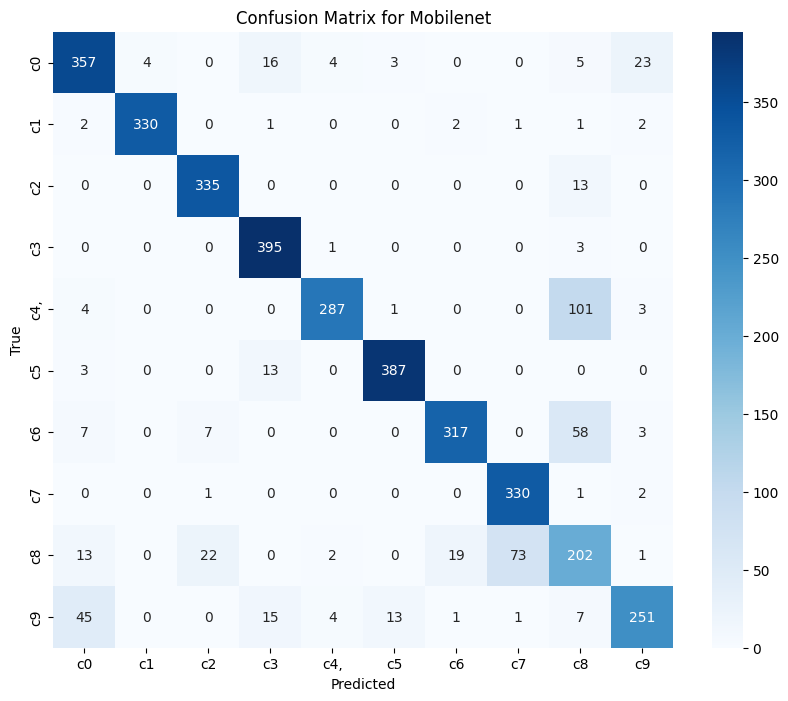

In [ ]:
 #Calculate confusion matrix
cm = confusion_matrix(true_test, model8_pred_class)
labels = ['c0','c1','c2','c3','c4,','c5','c6','c7','c8','c9']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Mobilenet')
plt.show()

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model8_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

### Ensembling

In [ ]:
from statistics import mean,median


ensemble_predictions = []
predictions = []

for i in range(len(X_test)):
#for i in range(1):
    mean_prediction = []

    for j in range(len(y_test[0])):
        predictions.append(model1_prediction[i][j])
#         predictions.append(model2_prediction[i][j])
        predictions.append(model3_prediction[i][j])
#         predictions.append(model4_prediction[i][j])
#         predictions.append(model5_prediction[i][j])
#         predictions.append(model6_prediction[i][j])
        #predictions.append(model7_prediction[i][j])
        predictions.append(model8_prediction[i][j])

        #print(predictions)

        trimmed_value = (sum(predictions) - max(predictions) - min(predictions))/(len(predictions) - 2)

        mean_value = mean(predictions)

        predictions = []
        mean_prediction.append(trimmed_value)

    mean_prediction = mean_prediction/ sum(mean_prediction)
    ensemble_predictions.append(mean_prediction)


ensemble_predictions = np.asarray(ensemble_predictions)



In [ ]:
ensemble_class = []

for i in range(len(ensemble_predictions)):
    ensemble_class.append(np.where(ensemble_predictions[i] == np.amax(ensemble_predictions[i]))[0][0])


In [ ]:
print('The accuracy of this model over validation set is:',accuracy_score(true_test,ensemble_class))

The accuracy of this model over validation set is: 0.8800108342361863


In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, ensemble_predictions, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.35
